# Section 12

## Assignment

### Part I: AST4031 and AST5031

1. Create a fake 2D dataset made out of 5 "Gaussian blobs" centered at $[2,2]$, $[-2,-2]$, $[2,-2]$, $[-1,1]$ and $[-0.5,0.5]$, all with the same standard deviation of 0.5.
2. Make a plot highlighting the true blob membership of each point. [_Tip: do not recreate the point distribution multiple times._]
3. Read about the scikit implementation of various clustering algorithms here:

    [https://scikit-learn.org/stable/modules/clustering.html](https://scikit-learn.org/stable/modules/clustering.html)

    1. Read about the parameter settings of KMeans.
        1. Apply the K-mean algorithm to the blob dataset. Explore how the results change as you change: `n_init` and `n_clusters`.
        1. Make the same plot as in _Question 2_, but now use the membership you found with K-mean.
    2. Read about the parameter settings of the agglomorative clustering algorithm.
        1. Apply the algorithm to the blobs. Make a plot showing the linked members of the clusters.
        2. Explore how the results change as you change the `n_clusters`, `linkage`, and the `affinity` parameters.
    3. Read about the parameter settings of the mean shift algorithm.
        1. Apply the algorithm to the blobs. 
        2. Explore how the results change as you change the `bandwidth`.

In [1]:
import numpy as np
import collections
import sklearn.datasets as skdsets
import sklearn.cluster as skcluster
import matplotlib.pyplot as mplplot

from IPython.display import display, Math, Latex

%matplotlib inline
%load_ext lab_black

### Solution
Rather than generate the gaussian blobs by hand, we can just use [the `make_blobs` function](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html) provided by the `sklearn.datasets` module. Easy!

In [2]:
blobCentres = [[2, 2], [-2, -2], [2, -2], [-1, 1], [-0.5, 0.5]]
coordinates, trueLabels = skdsets.make_blobs(
    n_samples=1000, centers=blobCentres, cluster_std=0.5
)

Now let's define a function to plot our generated data colourized according to set of point labels we specify. We'll also allow a set of axes to be passed to our function, in which case the colourized data will be plotted on those axes, rather than on a new, separate figure. This will be useful later when we want to plot large grids illustrating multiple clustering options.

In [3]:
def plotClusters(coordinates, labels, axes=None):

    blobAxes = (
        mplplot.figure(figsize=(7, 7)).add_subplot(1, 1, 1)
        if axes is None
        else axes
    )
    numLabels = np.unique(labels).size
    scatterData = blobAxes.scatter(
        *coordinates.T,
        s=7,
        c=labels + 1,
        vmin=0.5,
        vmax=numLabels + 0.5,
        cmap=mplplot.get_cmap("viridis", numLabels)
    )
    blobAxes.set_xlabel("X", fontsize="x-large")
    blobAxes.set_ylabel("Y", fontsize="x-large")
    blobColourBar = mplplot.colorbar(scatterData, ax=blobAxes)
    blobColourBar.set_label("Cluster Label", fontsize="x-large")
    mplplot.tight_layout()

To answer question 2, let's invoke our function, passing the true labels.

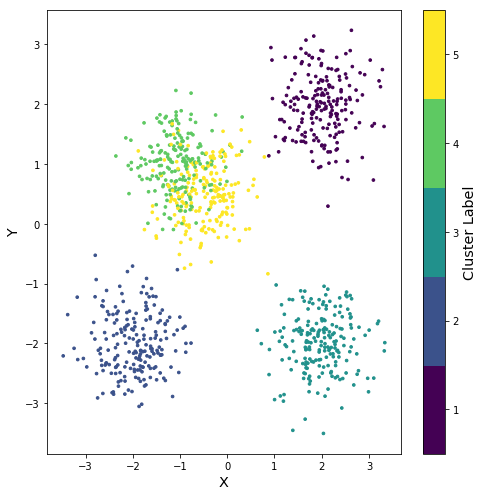

In [4]:
plotClusters(coordinates, trueLabels)

Now we'll begin investigating differet clustering algorithms. Let's start with K-means. We'll use the `sklearn.cluster.KMeans` implementation of the K-means algorithm.

We want to test several possible combinations of the `n_init` and `n_clusters` hyperparameters to observe their effects.
* The `n_clusters` parameters defines the number of clusters that the algorithm will attempt to identify.
* The `n_init` parameter defines the number of times that the clustering algorithm will run, starting each time with `n_clusters` randomly initialized starting cluster centres. The final result is derived from the run that resulted in the highest _inertia_ of the final clustered state. _Inertia_ is defined as the sum of squared distances of samples to their closest cluster center.

We'll define two ranges of hyper-parameter values.

In [5]:
nInitVals = np.arange(1, 10, 2)
nClusterVals = np.arange(1, 10, 2)
display(Latex("n_init $\in$ {}\n".format(nInitVals)))
display(Latex("n_clusters $\in$ {}".format(nClusterVals)))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Now we can compute the K-means cluster labels for all possible combinations of  `n_init` and `n_clusters`. We'll use a `dict` comprehension expression, which is similar to a list comprehension, but (in this case) returns a `dict` with _values_ corresponding to derived cluster labels and _keys_ that are tuples holding the hyperparameter values to which the labels pertain.

In [6]:
kMeansLabels = {
    (nInitVal, nClusterVal): skcluster.KMeans(
        n_init=nInitVal, n_clusters=nClusterVal
    ).fit_predict(X=coordinates)
    for nInitVal in nInitVals
    for nClusterVal in nClusterVals
}

Now, let's make a grid of plots showing the computed cluster membership for each of the hyper-parameter combinations. 

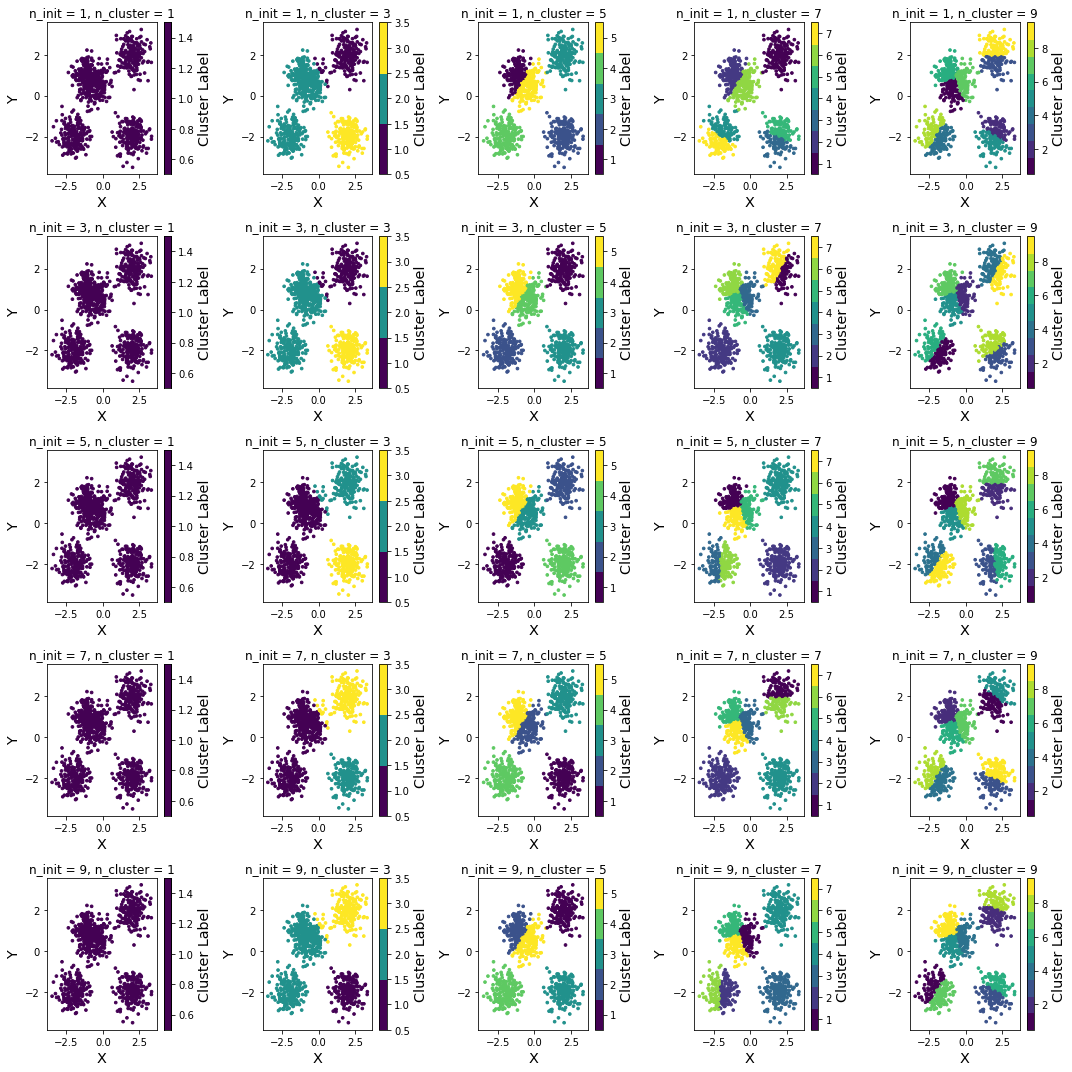

In [7]:
kMeansFigure, kMeansPanels = mplplot.subplots(
    figsize=3 * np.array((nClusterVals.size, nInitVals.size)),
    nrows=nInitVals.size,
    ncols=nClusterVals.size,
)

for kMeansPanel, ((nInitVal, nClusterVal), labels) in zip(
    kMeansPanels.flatten(), kMeansLabels.items()
):
    plotClusters(coordinates, labels, axes=kMeansPanel)
    kMeansPanel.set_title(
        "n_init = {}, n_cluster = {}".format(nInitVal, nClusterVal)
    )
mplplot.tight_layout()

We observe that (in this case) using a large `n_init` does not markedly change the distribution of the clustered points for `n_clusters` below 6. For `n_clusters`$\geq$6, the K-means algorithm is able to find different solutions depending upon the initialization locations of the cluster centres, so the trial solution with the highest inertia can reflect a different cluster distribution.  Note that although the algorithm does not accurately separate the overlapping clusters when 5 clusters are assumed. The algorithm does split the compound super-cluster, which is encouraging.

Now we can experiment with _Agglomerative clustering_.  We are asked to experiment using different values for the `n_clusters`, `linkage`, and the `affinity` hyper-parameters.
* We will use the same range of `n_clusters` values as we did for K-means.
* We'll make use of the `sklearn.cluster.AgglomerativeClustering` implementation, which supports four options for the `linkage`, namely `"ward"`, `"complete"`, `"average"` and `"single"`. Quoting from the [online documentation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html):
    * `"ward"` minimizes the variance of the clusters being merged.
    * `"average"` uses the average of the distances of each observation of the two sets.
    * `"complete"` (or maximum) linkage uses the maximum distances between all observations of the two sets.
    * `"single"` uses the minimum of the distances between all observations of the two sets.
* Agglomerative clustering groups points based on the distance beween them. The affinity hyper-parameter specifies a [metric](https://en.wikipedia.org/wiki/Hierarchical_clustering#Metric) that is used to compute that distance. `sklearn.cluster.AgglomerativeClustering` allows the `affinity` hyper-parameter to be one of `"euclidean"`, `"l1"`, `"l2"`, `"manhattan"`, `"cosine"`, or `"precomputed"`, but note that `"euclidean"` and `"l2"` are equivalent, as are `"l2"` and `"manhattan"`. We will ignore the `"precomputed"` option and focus on `"euclidean"`, `"manhattan"` and `"cosine"`. One thing to note is that when `"ward"` linkage is specified, only `"euclidean"` affinity is supported.

As a technical note Python `dict` objects do not guarantee insertion and extraction ordering. So that we can arrange our plots into groups that are adjacent in terms of the hyper-parameters we'll use the `collections.OrderedDict` class which provides `dict`-like data storage, but **does** maintain the order of its elements

In [8]:
linkageVals = ["ward", "complete", "average", "single"]
affinityVals = ["euclidean", "manhattan", "cosine"]

agglomerativeLabels = collections.OrderedDict(
    {
        (
            linkageVal,
            nClusterVal,
            affinityVal,
        ): skcluster.AgglomerativeClustering(
            linkage=linkageVal, n_clusters=nClusterVal, affinity=affinityVal
        ).fit_predict(
            X=coordinates
        )
        if not ("ward" in linkageVal and not "euclidean" in affinityVal)
        else None
        for affinityVal in affinityVals
        for linkageVal in linkageVals
        for nClusterVal in nClusterVals
    }
)

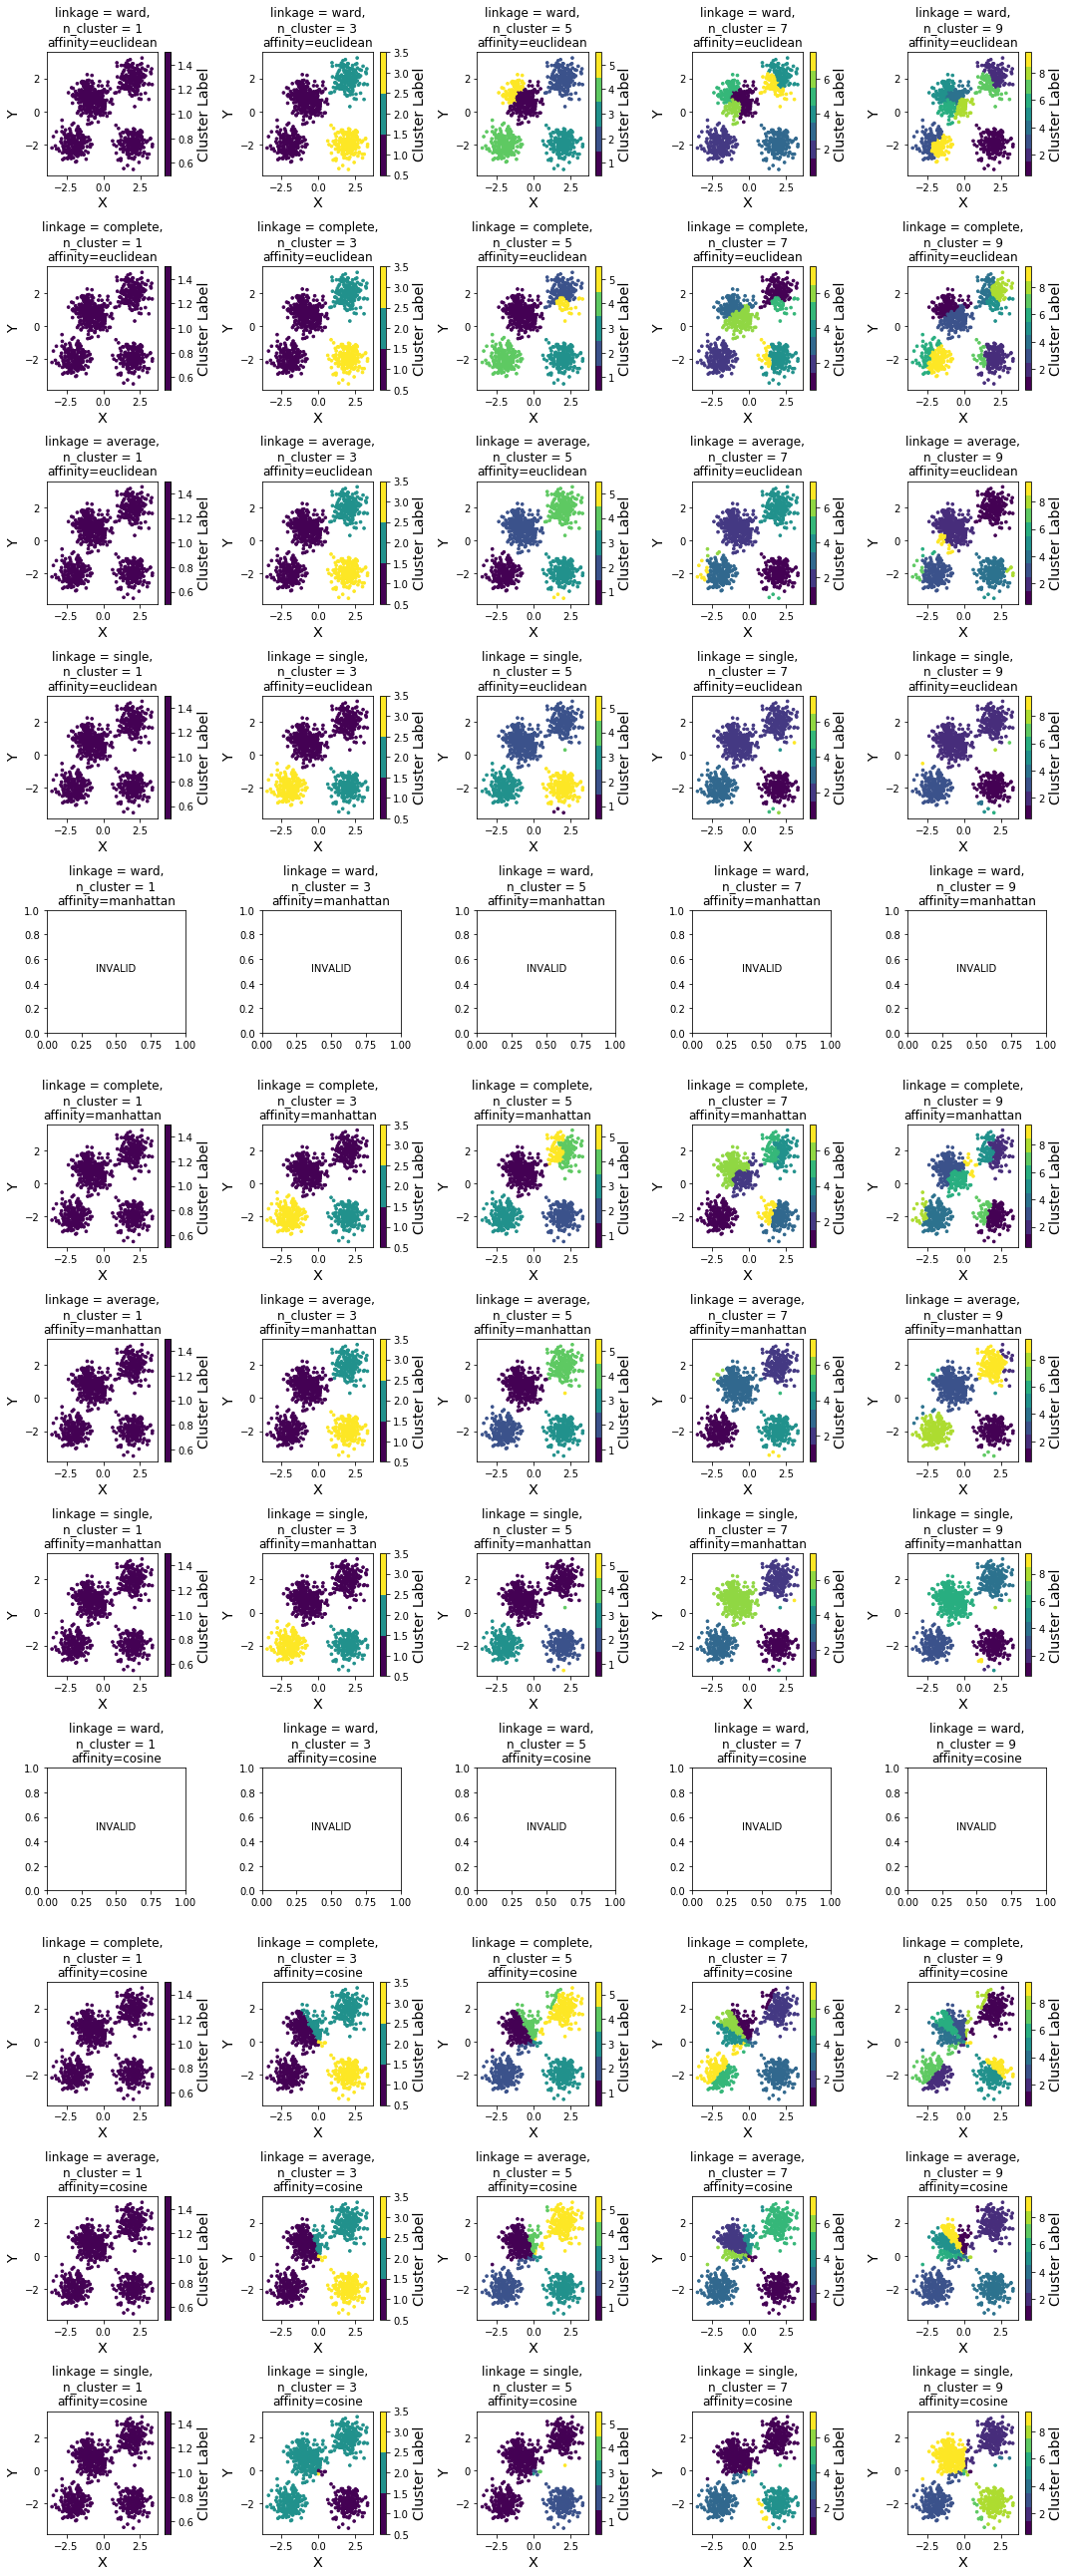

In [9]:
agglomerativeFigure, agglomerativePanels = mplplot.subplots(
    figsize=3
    * np.array((nClusterVals.size, len(linkageVals) * len(affinityVals))),
    nrows=len(linkageVals) * len(affinityVals),
    ncols=nClusterVals.size,
)

for agglomerativePanel, ((linkageVal, nClusterVal, affinityVal), labels) in zip(
    agglomerativePanels.flatten(), agglomerativeLabels.items()
):
    if labels is not None:
        plotClusters(coordinates, labels, axes=agglomerativePanel)
    else:
        agglomerativePanel.text(
            x=0.5, y=0.5, s="INVALID", fontdict=dict(ha="center")
        )
    agglomerativePanel.set_title(
        "linkage = {},\nn_cluster = {}\naffinity={}".format(
            linkageVal, nClusterVal, affinityVal
        )
    )
mplplot.tight_layout()

We observe that both `affinty` and `linkage` affect the clusters that are identified by the _Agglomorative Clustering_ algorithm. Both `"manhattan"` and `"cosine"` affinity appear prone to fragment clusters when `n_clusters`$\gtrsim$4. This propensity is most severe for `"complete"` and `"average"` linkage. 

In general `"single"` linkage is reluctant to identify more than 2 clusters for any `n_clusters` or `affinity` values. This is primarily because the three clusters in the upper and left quadrants are all closer to another cluster than they are to the cluster in the lower right.

Overall the default configuration `"ward"` `linkage` and `"euclidean"` `affinity` appears to yield clusters that most accurately represent the true cluster distribution.

Finally for this part, we'll run some experiments using the _Mean Shift_ clustering algorithm using the `sklearn.cluster.mean_shift` implementation.

The _Mean Shift_ algorithm begins by computing a large number of candidate cluster centroids by computing the mean position of the data points within a large number of randomly positioned, finite sized (hyper)spherical region of the clustering parameter space. It then follows an iterative procedure whereby each centroid is shifted towards the mean position of all the other centroids within the similarly sized "neighbourhood" around the centroid. With each iteration, the centroids converge towards the region with the highest density of data points in their dynamically evoloving neighbourhoods.

The _Mean Shift_ is designed to identify overdense regions of data as clusters and does not require a target cluster count (analogous to `n_clusters` in the previous examples). Instead the user sets the size of the neighbourhood region using the `bandwidth` parameter. 

We'll investigate the effect of the `bandwidth` parameter using 25 logarithmically spaced trial values between 0.1 and 2.

In [10]:
bandWidthVals = np.logspace(-1, np.log10(2), 25)
meanShiftLabels = {
    bandWidthVal: skcluster.mean_shift(X=coordinates, bandwidth=bandWidthVal)[1]
    for bandWidthVal in bandWidthVals
}

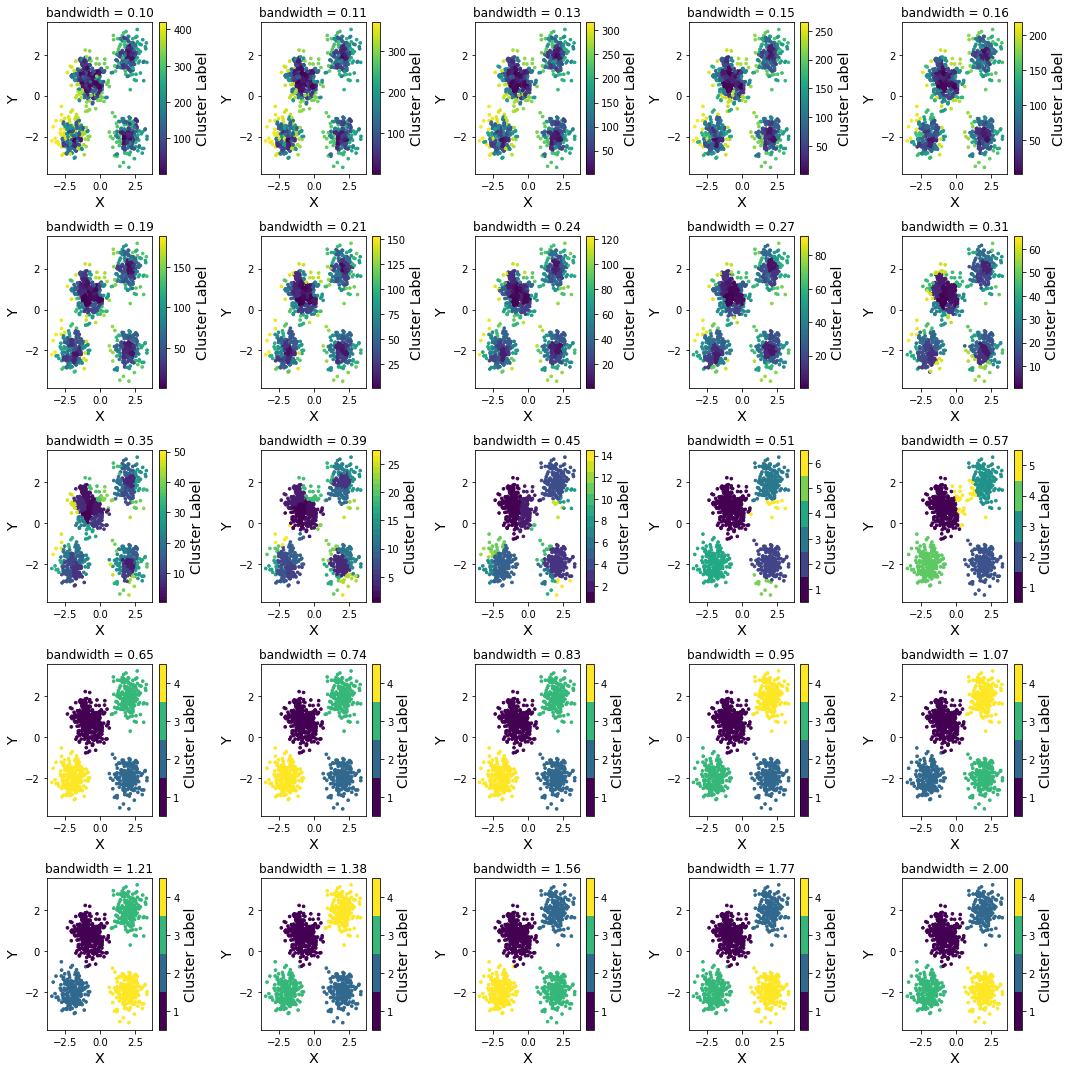

In [11]:
meanShiftFigure, meanShiftPanels = mplplot.subplots(
    figsize=3 * np.repeat(int(np.sqrt(bandWidthVals.size)), 2),
    nrows=int(np.sqrt(bandWidthVals.size)),
    ncols=int(np.sqrt(bandWidthVals.size)),
)

for meanShiftPanel, (bandWidthVal, labels) in zip(
    meanShiftPanels.flatten(), meanShiftLabels.items()
):
    plotClusters(coordinates, labels, axes=meanShiftPanel)
    meanShiftPanel.set_title("bandwidth = {:.2f}".format(bandWidthVal))

As we might have expected, given our understanding of the algorithm, small values of the bandwidth find small overdensities in the data distribution and identify a large number of small clusters. Only once the bandwidth becomes comparable to the cluster separation, does the algorithm begin to recover the true cluster distribution. Even so, it never identifies that the upper-left cluster is in fact a superposition of two true clusters.

### Part II: AST5031 only
1. Use the "gap statistic" to find the best number of clusters, for K-mean:
    1. Create 20 realizations of a database with uniformly distributed points in 2D, in the same range as the observed data, with uniform distribution in a box, whose sizes will have to be determined from the real data
    2. Define a routine that, for each K, computes the total within-cluster-distance squared (L in lecture).
    3. For each K compare L computed for the dataset with the average of the 20 simulated datasets.
    4. Make a plot showing the _Gap_ statistic as a function of the number of clusters. Describe how you chose the best K.

### Solution
We will need to produce  two dimensional coordinates uniformly distributed with specific bounds. Let's write a function to do that. We'll let the function compute the required bounds to be the coordinate ranges spanned by an input dataset that we provide. We'll allow the caller to specify a specific numper of coordinate pairs to generate, but will default to generating the same number of points as the input dataset if no specific sample count is requested.

In [12]:
def uniformInDataBounds(data, numSamples=None):
    assert data.shape[0] >= 2
    dimensionRanges = np.array(
        [[dimensionData.min(), dimensionData.max()] for dimensionData in data]
    )
    uniformCoordinates = np.array(
        [
            np.random.uniform(
                *dimensionRange,
                data[0].size if numSamples is None else numSamples
            )
            for dimensionRange in dimensionRanges
        ]
    )
    return uniformCoordinates

Let's test our function by plotting the uniformly distributed data it generates on the same axes as the data from which the bounds were inferred.

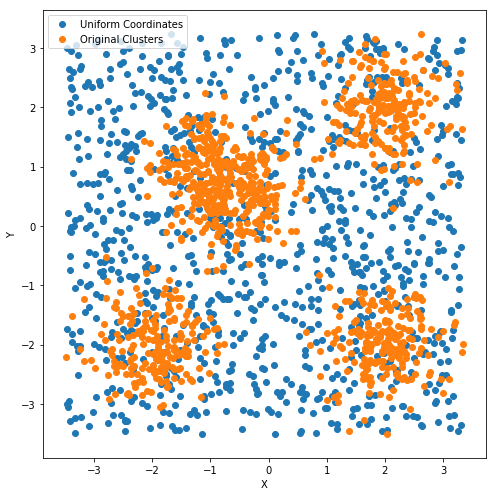

In [13]:
uniformBoxAxes = mplplot.figure(figsize=(7, 7)).add_subplot(1, 1, 1)

uniformBoxAxes.scatter(
    *uniformInDataBounds(coordinates.T), label="Uniform Coordinates"
)
uniformBoxAxes.scatter(*coordinates.T, label="Original Clusters")

uniformBoxAxes.set_xlabel("X")
uniformBoxAxes.set_ylabel("Y")

uniformBoxAxes.legend(loc="upper left")

mplplot.tight_layout()

Now let's complete part B by defining a function that computes the total **within-cluster** variation, summed over all clusters $k\in\{1\ldots K\}$.
\begin{equation}
L=\sum\limits_{k=1}^{K}\sum\limits_{i\in k}||x_{i}-\mu_{k}||^{2}
\end{equation}

In [14]:
def computeL(coordinates, labels):
    clusterSpreads = []
    for label in np.unique(labels):
        clusterData = coordinates[labels == label]
        clusterMean = np.array(
            [
                np.mean(clusterDimensionData)
                for clusterDimensionData in clusterData.T
            ]
        ).T
        clusterDistances = clusterData - clusterMean
        clusterSpreads.append(
            np.sum(np.sum(clusterDistances ** 2, axis=1) ** 2)
        )

    return np.sum(clusterSpreads)

For a specific number of clusters $K$, the **gap statistic** is defined following

\begin{equation}
\mathrm{Gap}(K) = E(\log_{10}L_{\mathrm{uniform}}(K))-\log_{10}L(K)
\end{equation}

where $L_{\mathrm{uniform}}(K)$ is computed for a simulated set of coordinates, uniformly distributed within the coordinate bounds of the dataset used to compute $L(K)$ and for which we are attempting to determine the optimal cluster number.

We will compute the expectation (average) $E(\log_{10}L_{\mathrm{uniform}}(K))$ and its associated standard error $s(K)$ using 20 independently generated uniform coordinate datasets.

Let's write a function to do that.


In [15]:
def computeGapForK(
    coordinates,
    k,
    numUniformSimulations=20,
    kMeansKeywords=dict(n_init=10),
    verbose=False,
):
    if verbose:
        print("Computing gap statistic for k = {}".format(k))
    ## Generate uniform simulations
    uniformSimulations = np.array(
        [
            uniformInDataBounds(
                coordinates.T, numSamples=coordinates[:, 0].size
            ).T
            for _ in range(numUniformSimulations)
        ]
    )
    ## Compute mean and standard dev. L for simulations
    simLogLValues = [
        np.log10(
            # Compute L
            computeL(
                simCoordinates,
                # Run clustering for simulation
                skcluster.KMeans(n_clusters=k, **kMeansKeywords).fit_predict(
                    X=simCoordinates
                ),
            )
        )
        for simCoordinates in uniformSimulations
    ]
    meanLogSimL = np.mean(simLogLValues)
    stdLogSimL = np.std(simLogLValues)
    ## Compute L for real data
    dataL = computeL(
        coordinates,
        # Run clustering for simulation
        skcluster.KMeans(n_clusters=k, **kMeansKeywords).fit_predict(
            X=coordinates
        ),
    )

    ## Compute gap
    gap = meanLogSimL - np.log10(dataL)
    ## Compute standard error
    stdError = stdLogSimL / np.sqrt(1 + (1 / numUniformSimulations))

    return gap, stdError

Now let's compute the gap statistic and $s(K)$ for a range of cluster counts $k\in\{1\ldots9\}$.

In [16]:
gapAndStdErr = [
    computeGapForK(coordinates, k, verbose=True) for k in range(1, 10)
]

Computing gap statistic for k = 1
Computing gap statistic for k = 2
Computing gap statistic for k = 3
Computing gap statistic for k = 4
Computing gap statistic for k = 5
Computing gap statistic for k = 6
Computing gap statistic for k = 7
Computing gap statistic for k = 8
Computing gap statistic for k = 9


Now we can plot the computed gap statistic values as a function of the trial cluster count, $k$.

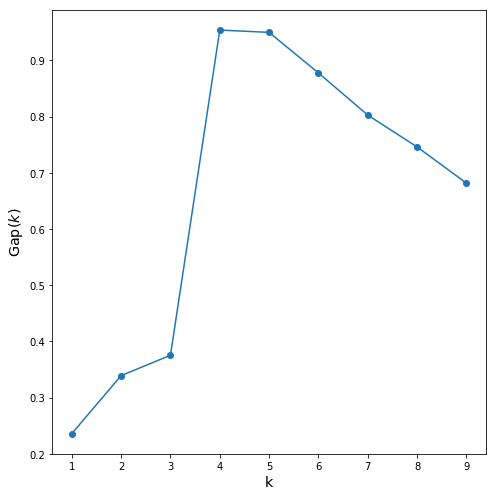

In [17]:
gapStatAxes = mplplot.figure(figsize=(7, 7)).add_subplot(1, 1, 1)

gapStatAxes.plot(
    np.arange(len(gapAndStdErr)).astype(int) + 1,
    np.array(gapAndStdErr)[:, 0],
    marker="o",
)
gapStatAxes.set_xlabel("k", fontsize="x-large")
gapStatAxes.set_ylabel("$\mathrm{Gap}(k)$", fontsize="x-large")
mplplot.tight_layout()

To identify the most likely number of clusters usingthis analysis we can use the prescription from [Tibshirani et al. (2001)](https://web.stanford.edu/~hastie/Papers/gap.pdf), which states that the most likely cluster count $K$ is the lowest for which 
\begin{equation}
\mathrm{Gap}(K) \geq \mathrm{Gap}(K+1) - s(K+1)
\end{equation}
Let's plot difference between the left and right hand sides of this inequality versus $K$ and find the lowest value of K for which this difference is greater than zero.

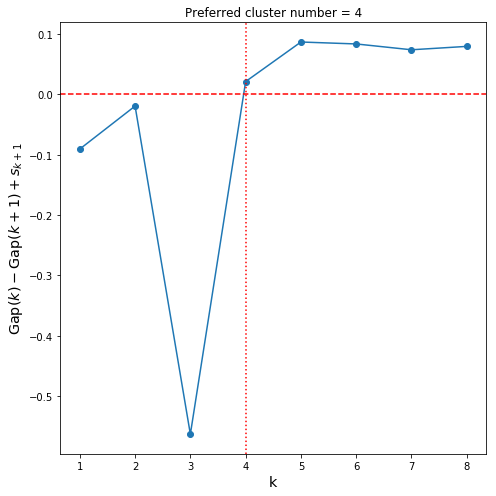

In [18]:
clusterSelectionAxes = mplplot.figure(figsize=(7, 7)).add_subplot(1, 1, 1)

selectionMetric = (
    np.array(gapAndStdErr)[:-1, 0]
    - np.array(gapAndStdErr)[1:, 0]
    + np.array(gapAndStdErr)[1:, 1]
)

clusterSelectionAxes.plot(
    np.arange(len(gapAndStdErr) - 1).astype(int) + 1,
    selectionMetric,
    marker="o",
)

preferredClusterCount = np.flatnonzero(selectionMetric > 0)[0] + 1

clusterSelectionAxes.axhline(y=0, c="r", ls="--")
clusterSelectionAxes.axvline(x=preferredClusterCount, c="r", ls=":")


clusterSelectionAxes.set_xlabel("k", fontsize="x-large")
clusterSelectionAxes.set_ylabel(
    "$\mathrm{Gap}(k)-\mathrm{Gap}(k+1) + s_{k+1}$", fontsize="x-large"
)
clusterSelectionAxes.set_title(
    "Preferred cluster number = {}".format(preferredClusterCount)
)
mplplot.tight_layout()

We find that for this particular realization of gaussian clusters and uniform simulation, the prefered number of clusters is 4 (but only just!).